In [1]:
pip install planetary-computer pystac-client

  Using cached python_dotenv-1.0.0-py3-none-any.whl (19 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

crop_yield_data = pd.read_csv('Crop_Location_Data.csv')
crop_yield_data.shape

(600, 2)

In [2]:
crop_yield_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [3]:
'''
Pre-process the orginial eval dataset.
'''

import pandas as pd

# Function to convert string to tuple and get the first element
def get_first_element(string_tuple):
    float_tuple = tuple(map(float, string_tuple.strip('()').split(',')))
    return float_tuple[0]

# Function to convert string to tuple and get the first element
def get_second_element(string_tuple):
    float_tuple = tuple(map(float, string_tuple.strip('()').split(',')))
    return float_tuple[1]

# Apply the function to the DataFrame column
crop_yield_data['latitude'] = crop_yield_data['Latitude and Longitude'].apply(get_first_element)

# Apply the function to the DataFrame column
crop_yield_data['longitude'] = crop_yield_data['Latitude and Longitude'].apply(get_second_element)

# Print the DataFrame
crop_yield_data.head()


,Latitude and Longitude,Class of Land,latitude,longitude
0,"(10.323727047081501, 105.2516346045924)",Rice,10.323727,105.251635
1,"(10.322364360592521, 105.27843410554115)",Rice,10.322364,105.278434
2,"(10.321455902933202, 105.25254306225168)",Rice,10.321456,105.252543
3,"(10.324181275911162, 105.25118037576274)",Rice,10.324181,105.251180
4,"(10.324635504740822, 105.27389181724476)",Rice,10.324636,105.273892


In [4]:
crop_yield_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Latitude and Longitude  600 non-null    object 
 1   Class of Land           600 non-null    object 
 2   latitude                600 non-null    float64
 3   longitude               600 non-null    float64
dtypes: float64(2), object(2)
memory usage: 18.9+ KB


In [5]:
def download_sentinel2_data(latitude, longitude):
    '''
    Returns XArray
    '''
    # Supress Warnings 
    import warnings
    warnings.filterwarnings('ignore')

    # Import common GIS tools
    import numpy as np
    import xarray as xr
    import matplotlib.pyplot as plt
    import rasterio.features
    import rioxarray as rio
    import xrspatial.multispectral as ms

    # Import Planetary Computer tools
    import pystac_client
    import planetary_computer as pc
    import odc
    from odc.stac import stac_load
    from odc.algo import to_rgba

    # Sample Rice Crop Field in An Giang, Vietnam
    lat_long = (latitude, longitude) # Lat-Lon centroid location
    box_size_deg = 0.10 # Surrounding box in degrees

    # Calculate the Lat-Lon bounding box region
    min_lon = lat_long[1]-box_size_deg/2
    min_lat = lat_long[0]-box_size_deg/2
    max_lon = lat_long[1]+box_size_deg/2
    max_lat = lat_long[0]+box_size_deg/2
    bounds = (min_lon, min_lat, max_lon, max_lat)
    '''
    # Define the time window   
    if season == 'SA':
        time_window = "2022-05-01/2022-08-31"
    if season == 'WS':
        time_window = "2022-01-01/2022-04-30"
    '''
    time_window = "2022-01-01/2022-12-01"

    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(collections=["sentinel-2-l2a"], bbox=bounds, datetime=time_window)
    items = list(search.get_all_items())
    # print('This is the number of scenes that touch our region:',len(items))

    # Define the pixel resolution for the final product
    # Define the scale according to our selected crs, so we will use degrees
    resolution = 20  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

    xx = stac_load(
        items,
        bands=["red", "nir"],
        crs="EPSG:4326", # Latitude-Longitude
        resolution=scale, # Degrees
        chunks={"x": 2048, "y": 2048},
        dtype="uint16",
        patch_url=pc.sign,
        bbox=bounds
    )

    # Calculate the mean of the data across the sample region
    mean = xx.mean(dim=['latitude','longitude']).compute()
    # Calculate NDVI
    mean['ndvi'] = (mean.nir-mean.red)/(mean.nir+mean.red)

    # Return XARRAY and the variables
    return mean

In [6]:
data_ds = download_sentinel2_data(crop_yield_data.latitude[0], crop_yield_data.longitude[0])
data_ds

<xarray.Dataset>
Dimensions:      (time: 63)
Coordinates:
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2022-01-05T03:21:31.024000 ... 2022-12...
Data variables:
    red          (time) float64 2.26e+03 504.1 574.7 ... 6.029e+03 3.804e+03
    nir          (time) float64 3.003e+03 2.497e+03 ... 5.86e+03 3.721e+03
    ndvi         (time) float64 0.1411 0.664 0.7216 ... -0.01423 -0.01102

In [7]:
# Download all the data
#from utils import *
import pandas as pd
import xarray as xr
import time

start = time.time()

data_ds = download_sentinel2_data(crop_yield_data.latitude[0], crop_yield_data.longitude[0])

for i in range(1, len(crop_yield_data)):
    ds = download_sentinel2_data(crop_yield_data.latitude[i], crop_yield_data.longitude[i])
    data_ds = xr.concat([data_ds, ds], dim='field')

print('Download time was: ', time.time() - start, ' sec.')

data_ds

Download time was:  3614.248490333557  sec.


<xarray.Dataset>
Dimensions:      (time: 64, field: 600)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-05T03:21:31.024000 ... 2022-12...
    spatial_ref  int32 4326
Dimensions without coordinates: field
Data variables:
    red          (field, time) float64 2.26e+03 504.1 nan ... 4.64e+03 2.871e+03
    nir          (field, time) float64 3.003e+03 2.497e+03 ... 4.471e+03
    ndvi         (field, time) float64 0.1411 0.664 nan ... 0.09518 0.2179

In [8]:
data_ds.to_netcdf('data_s2_ndvi.nc')

In [9]:
data_df = data_ds.to_dataframe()
data_df.shape

(38400, 4)

In [10]:
data_df = data_df.drop('spatial_ref', axis=1)
data_df.shape

(38400, 3)

In [11]:
data_df.head()

red          nir      ndvi
time                    field                                    
2022-01-05 03:21:31.024 0      2260.059365  3002.707599  0.141114
                        1      2659.376787  3331.496400  0.112191
                        2      2280.689356  3012.293492  0.138222
                        3      2252.772878  2997.484421  0.141843
                        4      2545.972040  3268.516473  0.124266

In [16]:
data_df['ndvi_ma'] = data_df.ndvi.rolling(window=1250).mean()  # 1114, 1671, 2228, 2785
data_df = data_df.fillna(0)

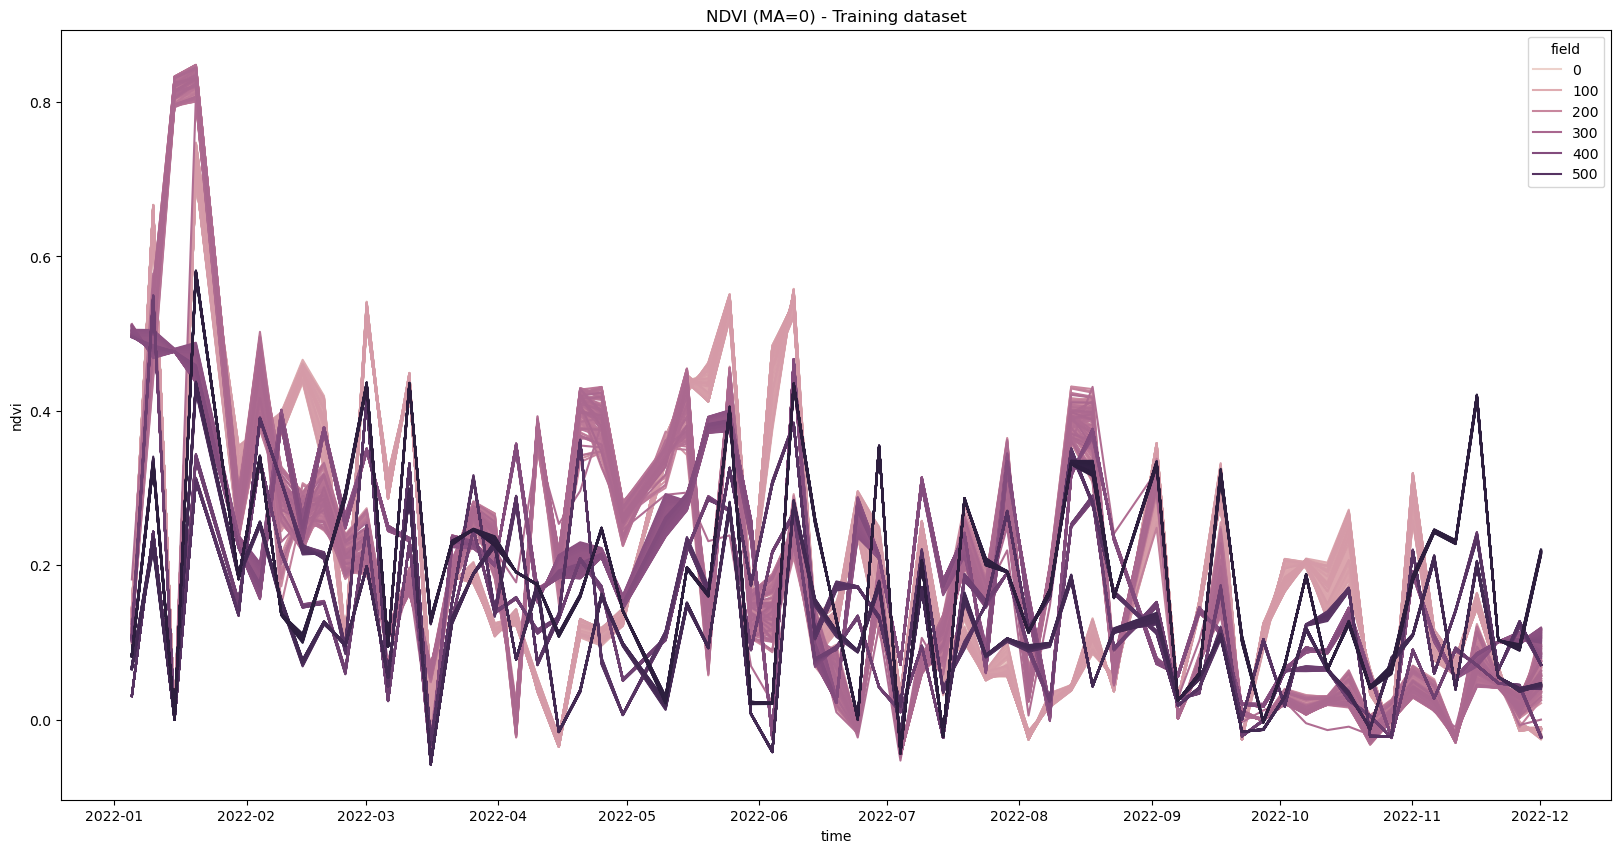

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=data_df, x="time", y="ndvi", hue='field').set(title='NDVI (MA=0) - Training dataset')

fig.savefig("data_ndvi.png") 

In [25]:
# Unstack the multi-level index
columns_to_drop = ['red', 'nir', 'ndvi_ma']
df = data_df.drop(columns_to_drop, axis=1).unstack(level='time')
df.shape

(600, 64)

In [26]:
import numpy as np

# Calculate the statistics for each row
df['max_value'] = df.max(axis=1)
df['min_value'] = df.min(axis=1)
df['mean'] = df.mean(axis=1)
df['std_dev'] = df.std(axis=1)
df['variance'] = df.var(axis=1)

# Autocorrelation
def autocorr(x, lag=1):
    return np.corrcoef(x[:-lag], x[lag:])[0, 1]

df['autocorrelation'] = df.apply(autocorr, axis=1)

df.shape


(600, 70)

In [29]:
df.head()

ndvi                                                  \
time  2022-01-05 03:21:31.024 2022-01-10 03:21:09.024 2022-01-15 03:21:01.024   
field                                                                           
0                    0.141114                0.664033                     0.0   
1                    0.112191                0.644632                     0.0   
2                    0.138222                0.662787                     0.0   
3                    0.141843                0.664241                     0.0   
4                    0.124266                0.652566                     0.0   

                                                                               \
time  2022-01-20 03:20:39.024 2022-01-30 03:19:49.024 2022-02-04 03:19:31.024   
field                                                                           
0                    0.721585                0.307432                0.385623   
1                    0.704481                0.247938                0.379278   
2                    0.722893                0.302338                0.385442   
3                    0.721522                0.309638                0.386013   
4                    0.704633                0.251400                0.381182   

                                                                               \
time  2022-02-09 03:18:59.024 2022-02-14 03:18:31.024 2022-02-19 03:17:49.024   
field                                                                           
0                    0.378426                0.451874                0.378745   
1                    0.372082                0.453206                0.341823   
2                    0.378153                0.456029                0.376793   
3                    0.378567                0.451100                0.379695   
4                    0.374873                0.450494                0.348163   

                               ...                          \
time  2022-02-24 03:17:31.024  ... 2022-11-16 03:20:09.024   
field                          ...                           
0                    0.094859  ...                0.146266   
1                    0.089836  ...                0.161671   
2                    0.092892  ...                0.149442   
3                    0.095295  ...                0.145722   
4                    0.095379  ...                0.154913   

                                                                               \
time  2022-11-21 03:20:31.024 2022-11-26 03:20:49.024 2022-12-01 03:21:11.024   
field                                                                           
0                    0.059834               -0.014229               -0.011017   
1                    0.056630               -0.003623               -0.020639   
2                    0.059473               -0.012917               -0.011283   
3                    0.059990               -0.014433               -0.010937   
4                    0.056851               -0.006366               -0.017805   

      max_value min_value      mean   std_dev  variance autocorrelation  
time        NaT       NaT       NaT       NaT       NaT             NaT  
field                                                                    
0      0.721585 -0.029840  0.199369  0.190267  0.035662        0.088949  
1      0.704481 -0.025654  0.196219  0.185344  0.033842        0.057628  
2      0.722893 -0.029995  0.199150  0.190511  0.035754        0.084475  
3      0.721522 -0.029973  0.199502  0.190288  0.035670        0.090378  
4      0.704633 -0.025343  0.197016  0.186225  0.034164        0.063851  

[5 rows x 70 columns]

In [31]:
# Save Pandas DataFrame to disk
df.to_csv('data_s2_ndvi.csv', index=False)